In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.15.0
OpenCV version: 4.9.0


Preprocesamiento de la imagen

In [91]:
def z_score_normalization(image):
    mean, std = image.mean(), image.std()
    return (image - mean) / std

def preprocess_image(image):
    if image is None:
        print(f"Error loading image.")
        return None, None
    
    image = cv2.resize(image, (224, 224)).astype(np.float32)
    kernel_size = 15
    
    low_freq_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    low_freq_image = z_score_normalization(low_freq_image)
    
    laplacian = cv2.Laplacian(image, cv2.CV_32F)
    
    high_freq_image = z_score_normalization(laplacian)
    
    return low_freq_image, high_freq_image

Preprocesamiento de la imagen v2

In [ ]:
def process_low_freq_image(image):
    if image is None:
        print(f"Error loading image.")
        return None
    
    image = cv2.resize(image, (224, 224)).astype(np.float32)
    
    eps = 0.1
    guided_filter = cv2.ximgproc.createGuidedFilter(image, radius=10, eps=eps)
    low_freq_image = guided_filter.filter(image)
    
    low_freq_image = z_score_normalization(low_freq_image)
    
    return low_freq_image

def process_high_freq_image(image):
    if image is None:
        print(f"Error loading image.")
        return None
    
    image = cv2.resize(image, (224, 224)).astype(np.float32)

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3) 
    sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)
    
    high_freq_image = cv2.magnitude(sobel_x, sobel_y)
    
    high_freq_image = np.float32(high_freq_image) 
    
    high_freq_image = z_score_normalization(high_freq_image)
    
    return high_freq_image

def preprocess_image2(image):
    low_freq_image = process_low_freq_image(image)
    high_freq_image = process_high_freq_image(image)
    
    return low_freq_image, high_freq_image

Test de preprocesamiento:

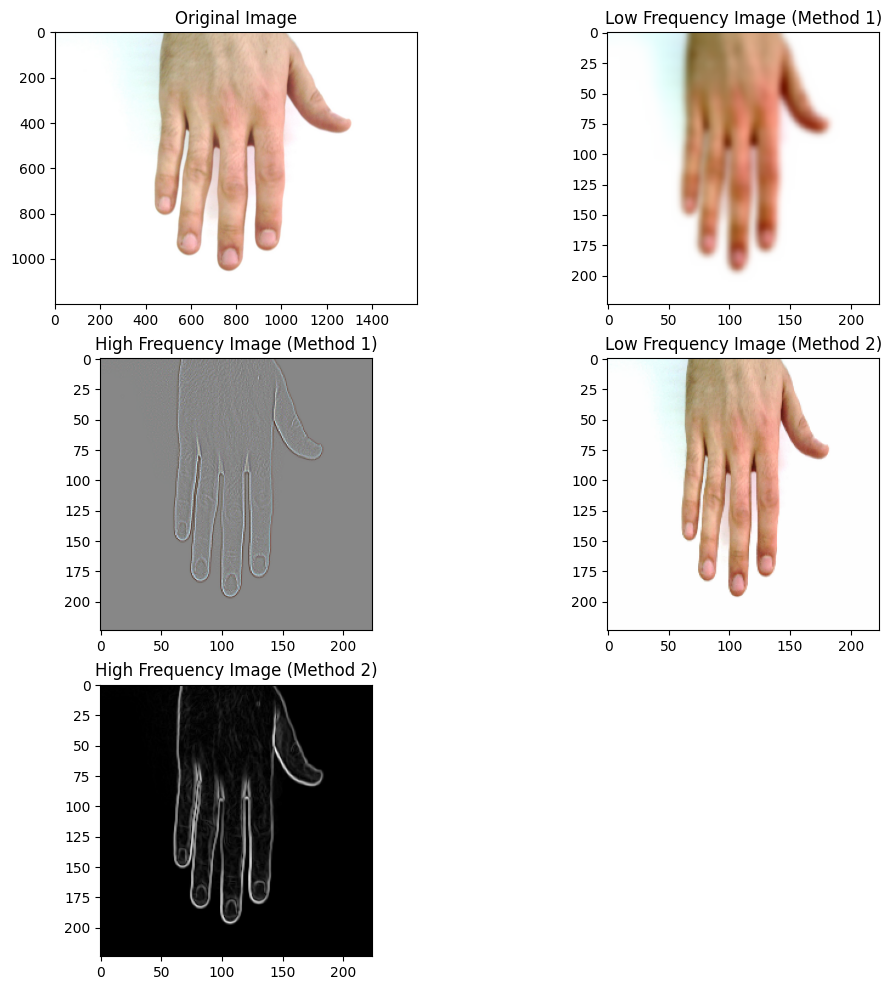

In [ ]:
img = cv2.imread("../dataset/Hands/Hand_0000002.jpg", cv2.IMREAD_COLOR)

l, h = preprocess_image(img)
l2, h2 = preprocess_image2(img)

def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) * 255
    normalized_image = np.uint8(normalized_image)
    return normalized_image

plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(3, 2, 2)
plt.title("Low Frequency Image (Method 1)")
plt.imshow(normalize(cv2.cvtColor(l, cv2.COLOR_BGR2RGB)))

plt.subplot(3, 2, 3)
plt.title("High Frequency Image (Method 1)")
plt.imshow(normalize(cv2.cvtColor(h, cv2.COLOR_BGR2RGB)))

plt.subplot(3, 2, 4)
plt.title("Low Frequency Image (Method 2)")
plt.imshow(normalize(cv2.cvtColor(l2, cv2.COLOR_BGR2RGB)))

plt.subplot(3, 2, 5)
plt.title("High Frequency Image (Method 2)")
plt.imshow(normalize(cv2.cvtColor(h2, cv2.COLOR_BGR2RGB)))

plt.show()

Carga y preprocesado del dataset

In [ ]:
def load_and_preprocess_data(dataset_path):
    image_folder = os.path.join(dataset_path, 'Hands')
    csv_file = os.path.join(dataset_path, 'HandInfo.csv') 
    csv = pd.read_csv(csv_file)
    low_freq_images = []
    high_freq_images = []
    labels = []
    
    for _, row in csv.iterrows():
        image_name = f"Hand_{row['id']}.jpg"
        gender = row['gender']
        image_path = os.path.join(image_folder, image_name)
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        low_freq, high_freq = preprocess_image(image)
        if low_freq is not None and high_freq is not None:
            low_freq_images.append(low_freq[..., np.newaxis])
            high_freq_images.append(high_freq[..., np.newaxis])
            labels.append(gender)
            
    unique_labels = list(set(labels))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = [label_map[label] for label in labels]
            
    return np.array(low_freq_images), np.array(high_freq_images), np.array(numeric_labels)